# Init

In [1]:
import configparser, os, sys

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import kaiser

config = "bruz"
if config == "ur1":
    sys.path.insert(0, "../")
    siepelDir = "C:/Users/pleroy/Documents/CAMILL/SER/WR15_v2"
elif config == "bruz":
    sys.path.insert(0, "/home/pleroy/DEV/DIADEM")
    siepelDir = "/home/pleroy/DATA/CAMILL/WR15_v2"

import toolsdiadem.tools as dia
import toolsdiadem.ser as ser
from toolsdiadem.ConfigSer2 import ConfigSer2
from toolsdiadem.Gate import Gate
from toolsdiadem.Probe import Probe

In [2]:
#%matplotlib qt5
%load_ext autoreload
%autoreload 2

In [3]:
cmap='jet'
conf = ConfigSer2(os.path.join(siepelDir, "wr15.ini"))
conf.printConfig()
dataShape = (conf.sup.nb_elev, conf.sup.nb_freq)

/home/pleroy/DATA/CAMILL/WR15_v2/wr15.ini
base_path (path to the ini file): /home/pleroy/DATA/CAMILL/WR15_v2
out_path (for the processing outputs): /home/pleroy/DATA/CAMILL/WR15_v2/processing/wr15
gateWidth 500.0
gateCenter 6450.0
centerFreq 62.5
bandWidth 12.4
idxElevation 20
vmin -90.0
vmax -40.0

SUPPORT
nb_elev 41
nb_freq 2001
nb_ssb 3
el0 0.7
az0 -0.44

REFERENCE
nb_elev 41
nb_freq 2001
nb_ssb 3
el0 0.31
az0 -0.44


In [4]:
withPlots = 0

## Fond de chambre

In [5]:
file_f2c = os.path.join(conf.out_path, "data", "WR15_S11_fond_de_chambre.txt")
tmp = np.loadtxt(file_f2c, skiprows=1)
print(file_f2c)
S11_f2c = tmp[:,1] + 1j * tmp[:,2]

/home/pleroy/DATA/CAMILL/WR15_v2/processing/wr15/data/WR15_S11_fond_de_chambre.txt


## Probe

In [6]:
file_probe = os.path.join(conf.base_path, "S11FDC_WR15.s1p")
probe = Probe(file_probe)
print(file_probe)

/home/pleroy/DATA/CAMILL/WR15_v2/S11FDC_WR15.s1p


## Plaque de référence

In [7]:
file_ref =  os.path.join(conf.out_path, "data", "WR15_S11_plaque_ref.txt")
tmp = np.loadtxt(file_ref, skiprows=1)
S11_reference = tmp[:, 1] + 1j * tmp[:, 2]
freq_reference = tmp[:, 0]
print(file_ref)
d = np.linspace(0, 300 / (freq_reference[1] - freq_reference[0]), conf.ref.nb_freq) * 0.5

/home/pleroy/DATA/CAMILL/WR15_v2/processing/wr15/data/WR15_S11_plaque_ref.txt


Text(0.5, 1.0, 'time domain, width 500 center 6450')

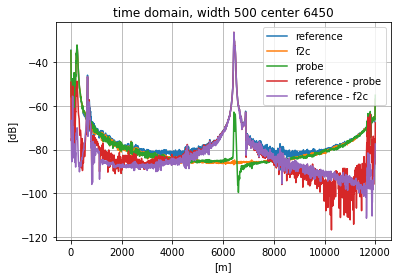

In [8]:
fig, ax = plt.subplots(1,1)
ax.plot(d, ser.dB(np.fft.ifft(S11_reference)), label="reference")
ax.plot(d, ser.dB(np.fft.ifft(S11_f2c)), label="f2c")
ax.plot(d, ser.dB(np.fft.ifft(probe.S11)), label="probe")
ax.plot(d, ser.dB(np.fft.ifft(S11_reference - probe.S11)), label="reference - probe")
ax.plot(d, ser.dB(np.fft.ifft(S11_reference - S11_f2c)), label="reference - f2c")
ax.grid()
ax.legend()
ax.set_xlabel("[m]")
ax.set_ylabel("[dB]")
ax.set_title(f"time domain, width {conf.gateWidth:.0f} center {conf.gateCenter:.0f}")

# Réflectivité
ref: ser4siepel_multiband_scan_elev_Reflectivite.sce

## Initialisation des variables

In [9]:
data_S11         = np.zeros(dataShape, dtype=complex)
data_S11_td      = np.zeros(dataShape, dtype=complex)
data_S11_tg      = np.zeros(dataShape, dtype=complex)
S11_minus_moy    = np.zeros(dataShape, dtype=complex)
S11_minus_moy_td = np.zeros(dataShape, dtype=complex)
S11_minus_moy_tg = np.zeros(dataShape, dtype=complex)
reflectivite     = np.zeros(dataShape, dtype=complex)
S11_moy          = np.zeros(conf.sup.nb_freq, dtype=complex)
S11_moy_square   = np.zeros(conf.sup.nb_freq, dtype=complex)

## Lecture des données et time gating

In [10]:
myGate = Gate(d, width=conf.gateWidth, center=conf.gateCenter)
gate = myGate.gateLLC

gateSize 167


In [11]:
conf.gateWidth, conf.gateCenter

(500.0, 6450.0)

## Calcul de la réflectivité

In [12]:
date, absorbant = "20200819", "065_AC"
#date, absorbant = "20200703", "013_0"
dir_abs = f"{conf.base_path}/{date}/{absorbant}"    
freq_all, data_S11 = ser.getData_ssb(conf.sup.nb_elev, conf.sup.nb_freq, conf.sup.nb_ssb, dir_abs)

d = np.linspace(0, 300 / (freq_all[1] - freq_all[0]), conf.sup.nb_freq) * 0.5

In [13]:
reflectivite = ser.getReflectivite(data_S11, S11_reference, S11_f2c, myGate.gateLLC)

In [14]:
S11_plaque_ref_tg = np.fft.fft(np.fft.ifft(S11_reference - S11_f2c) * gate)
S11_minus_fdc = data_S11 - S11_f2c
s11_minus_fdc_td = np.fft.ifft(S11_minus_fdc, axis=1)
s11_minus_fdc_tg = s11_minus_fdc_td * gate
S11_minus_fdc_tg = np.fft.fft(s11_minus_fdc_tg, axis=1)
reflectivite = S11_minus_fdc_tg / S11_plaque_ref_tg

s11_td = np.fft.ifft(data_S11, axis=1)
s11_td_plaqueRef = np.fft.ifft(S11_reference)

Text(0.5, 1.0, '065_AC 20200819, élévation 0.7°')

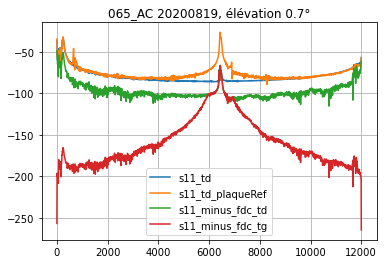

In [15]:
idx = 20
plt.figure()
plt.plot(d, ser.dB(s11_td[idx, :]), label="s11_td")
plt.plot(d, ser.dB(s11_td_plaqueRef), label="s11_td_plaqueRef")
plt.plot(d, ser.dB(s11_minus_fdc_td[idx, :]), label="s11_minus_fdc_td")
plt.plot(d, ser.dB(s11_minus_fdc_tg[idx, :]), label="s11_minus_fdc_tg")
plt.legend()
plt.grid()
plt.title(f"{absorbant} {date}, élévation {conf.sup.elevation[idx]}°")

## Plot

valMax = -31.77 valMin = -90.00


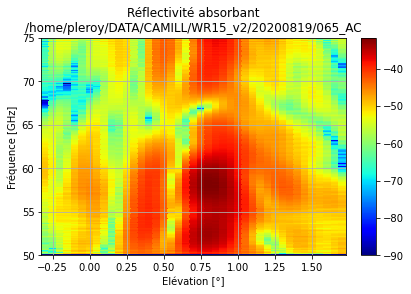

In [17]:
toPlot = np.zeros( (conf.sup.nb_elev, conf.sup.nb_freq) )
gatebis  = 0.0 * myGate.gateLLC
gatebis[np.where(np.abs(freq_all - conf.centerFreq) < conf.bandWidth)] = 1.0
toPlot = 20 * np.log10(1e-12 + np.abs(reflectivite * gatebis))

valMin = -90
toPlot = 0.5 * (np.abs(toPlot - valMin) + toPlot - valMin) + valMin
valMax = np.amax(toPlot)
valMin = np.amin(toPlot)
print( f"valMax = {valMax:.2f} valMin = {valMin:.2f}")
     
vmin = -80
vmax = -0
fig, ax = plt.subplots(1, 1)
im = plt.pcolormesh(conf.sup.elevation, np.flip(freq_all), np.rot90(toPlot), cmap=cmap, shading='auto')

title = f"Réflectivité absorbant\n{dir_abs}"
ax.set_title(title)
ax.set_xlabel("Elévation [°]")
ax.set_ylabel("Fréquence [GHz]")
dia.addColorBar( im, ax, aspect='auto')

# Tous les absorbants

20200701 = ["000_A", "001_C", "002_E", "003_W", "004_V", "005_G"]

20200703 = ["006_L", "007_M", "008_X", "009_H", "010_I", "011_K", "012_J", "013_O", "014_N", "015_D", "016_T", "017_AB_u", "018_N_u"]

**renamed**

20200701 = ["000_A", "001_C", "002_E", "003_W", "004_V", "005_G"]

20200703 = ["006_L", "007_M", "008_X", "009_H", "010_I", "011_K", "012_J", "013_O", "014_N", "015_AA", "016_Y", "017_AB", "018_Z"]

In [18]:
np.save(os.path.join(conf.out_path, "data", "freq_WR15"), freq_all)
np.save(os.path.join(conf.out_path, "data", "elevation_WR15"), conf.sup.elevation)

In [20]:
idx = np.where(np.abs(freq_all - conf.centerFreq) < conf.bandWidth)
idxAlt = np.where(np.abs(freq_all - conf.centerFreq) >= conf.bandWidth)

dic_stats = {}
toPlot = np.zeros(dataShape)

gate = myGate.gateLLC
date = "20200703" # 01, 03
date = "20200819"

for absorbant in conf.dic_dir[date]:

    seq = 0
    flag_gate = 1
    data_dir = f"{conf.base_path}/{date}/{absorbant}"
    descriptor = f"{absorbant}_{date}"
    
    print(f"======= {absorbant} =======")

    for ielev in range(conf.sup.nb_elev):
        freq_all, S11_all = ser.getFreqAndS11(data_dir, conf.sup.nb_ssb, seq0=seq, verbose=0)
        seq = seq + 3
        data_S11[ ielev, : ] = S11_all
    
    S11_plaque_ref_tg = np.fft.fft(np.fft.ifft(S11_reference - S11_f2c) * gate)
    tab_freq = freq_all
    S11_minus_moy    = data_S11 - S11_f2c
    S11_minus_moy_td = np.fft.ifft(S11_minus_moy, axis=1)
    S11_minus_moy_tg = np.fft.fft(S11_minus_moy_td * gate, axis=1)

    #=============
    # REFLECTIVITE
    reflectivite = np.zeros(dataShape, dtype=complex)
    reflectivite = S11_minus_moy_tg / S11_plaque_ref_tg
    np.save( 
        f"{conf.out_path}/data/reflectivite/{descriptor}",
        reflectivite 
    )
    
    # drop lower and higher frequencies values
    toPlot[:,idx] = 20 * np.log10(1e-12 + np.abs(reflectivite[:,idx]))
    toPlot[:,idxAlt] = -90

    fig, ax = plt.subplots( 1, 1 )
    im = ax.pcolormesh(conf.sup.elevation, np.flip(freq_all), np.rot90(toPlot), cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
    title = f"Réflectivité [{absorbant}]"
    ax.set_title(title)
    ax.set_xlabel("Elévation [°]")
    ax.set_ylabel("Fréquence [GHz]")
    dia.addColorBar(im, ax, aspect='auto')
    fig.savefig(
        f"{conf.out_path}/plot/reflectivite/reflectivite_{descriptor}.png"
    )

    #======
    # STATS
    valMax = np.amax(toPlot)
    valMin = np.amin(toPlot)
    print(f"valMax = {valMax:.2f} valMin = {valMin:.2f}")

    absReflectivite   = np.abs(reflectivite)
    reflectiviteMoy   = np.average(absReflectivite[:,idx])
    reflectiviteSigma = np.std(absReflectivite[:,idx])

    reflectiviteMoy_dB   = 20 * np.log10(np.abs(reflectiviteMoy))
    reflectiviteSigma_dB = 20 * np.log10(np.abs(reflectiviteSigma))
    print(f"moy = {reflectiviteMoy:.6f}, sigma = {reflectiviteSigma:.6f}")
    print(f"moy = {reflectiviteMoy_dB:.2f} [dB], sigma = {reflectiviteSigma_dB:.2f} [dB]")
    
    #==========
    # HISTOGRAM
    fig, ax = plt.subplots(1,1)
    ax.hist((absReflectivite[:,idx]).flatten(), 50, label="histogramme (valeurs linéaires)")
    ax.grid()
    title = f"Réflectivité, histogramme [{absorbant}]"
    ax.set_title(title)
    ax.legend()
    fig.savefig(
        f"{conf.out_path}/plot/hist/hist_{descriptor}.png"
    )
    
    #=====
    # PLOT
    fig, ax = plt.subplots(1,1)
    ax.plot(freq_all, toPlot[conf.idxElevation, :])
    ax.grid()
    title = f"Réflectivité [{absorbant}]"
    ax.set_title(title)
    ax.set_xlabel("f [GHz]")
    ax.set_ylabel("réflectivité [dB]")
    fig.savefig(
        f"{conf.out_path}/plot/reflectivite_vs_f/reflectivite_vs_f_{descriptor}.png"
    )
    
    plt.close("all")
    
    dic_stats[f"{descriptor}"] = (valMax, valMin, reflectiviteMoy, reflectiviteSigma, reflectiviteMoy_dB)

======= 065_AC =======
valMax = -31.77 valMin = -102.86
moy = 0.004809, sigma = 0.004614
moy = -46.36 [dB], sigma = -46.72 [dB]
======= 066_AD =======
valMax = -33.16 valMin = -103.53
moy = 0.004374, sigma = 0.004243
moy = -47.18 [dB], sigma = -47.45 [dB]


In [21]:
for absorbant in dic_stats.keys():
    stats = dic_stats[absorbant]
    print(f"{absorbant} {stats[0]:.2f} {stats[1]:.2f} {stats[2]:.6f} {stats[3]:.6f} {stats[4]:.2f}")

065_AC_20200819 -31.77 -102.86 0.004809 0.004614 -46.36
066_AD_20200819 -33.16 -103.53 0.004374 0.004243 -47.18
